In [2]:
import sys
sys.path.append("..")

In [3]:
import numpy as np
import logging
import pickle
import glob

from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import RobustScaler
from sklearn.utils import check_random_state

from scipy import interp

from recnn.preprocessing import permute_by_pt
from recnn.preprocessing import extract

%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (8,8)

# Data preparation

In [4]:
# prefixes = ["antikt-antikt", "antikt-antikt-trimmed",
#             "antikt-cambridge", "antikt-kt-delphes",
#             "antikt-kt-images", "antikt-kt", "antikt-kt-trimmed",
#             "antikt-random", "antikt-seqpt"]

# for prefix in prefixes:
#     print(prefix)

#     filename_train = "../data/w-vs-qcd/final/%s-train.pickle" % prefix
#     filename_test = "../data/w-vs-qcd/final/%s-test.pickle" % prefix

#     fd = open(filename_train, "rb")
#     X1, y1 = pickle.load(fd)
#     fd.close()

#     fd = open(filename_test, "rb")
#     X2, y2 = pickle.load(fd)
#     fd.close()

#     rng = check_random_state(1)
#     indices = rng.permutation(len(X1))

#     X_train = [X1[j] for j in indices[:100000]]
#     y_train = [y1[j] for j in indices[:100000]]
#     X_test = [X1[j] for j in indices[100000:]]
#     X_test.extend(X2)
#     y_test = [y1[j] for j in indices[100000:]]
#     y_test.extend(y2)

#     print(len(X_train), len(y_train))
#     print(len(X_test), len(y_test))

#     fd = open(filename_train, "wb")
#     pickle.dump((X_train, y_train), fd, protocol=2)
#     fd.close()

#     fd = open(filename_test, "wb")
#     pickle.dump((X_test, y_test), fd, protocol=2)
#     fd.close()

#     fd = open("%s-20k" % filename_test, "wb")
#     pickle.dump((X_test[:20000], y_test[:20000]), fd, protocol=2)
#     fd.close()

antikt-antikt
(100000, 100000)
(100000, 100000)
antikt-antikt-trimmed
(100000, 100000)
(100000, 100000)
antikt-cambridge
(100000, 100000)
(100000, 100000)
antikt-kt-delphes
(100000, 100000)
(100000, 100000)
antikt-kt-images
(80000, 80000)
(20000, 20000)
antikt-kt
(100000, 100000)
(100000, 100000)
antikt-kt-trimmed
(100000, 100000)
(100000, 100000)
antikt-random
(100000, 100000)
(100000, 100000)
antikt-seqpt
(100000, 100000)
(100000, 100000)


# Plotting functions

In [6]:
def load_tf(filename_train):
    # Make training data
    print("Loading training data...")

    fd = open(filename_train, "rb")
    X, y = pickle.load(fd)
    fd.close()
#     indices = np.random.permutation(len(X))
#     size = min(80000, len(X))
#     X = [X[i] for i in indices[:size]]
#     y = [y[i] for i in indices[:size]]
    y = np.array(y)

    print("\tfilename = %s" % filename_train)
    print("\tX size = %d" % len(X))
    print("\ty size = %d" % len(y))

    # Preprocessing 
    print("Preprocessing...")
    X = [extract(permute_by_pt(jet)) for jet in X]
    tf = RobustScaler().fit(np.vstack([jet["content"] for jet in X]))
    
    return tf

def load_test(tf, filename_test):
    # Make test data 
    print("Loading test data...")

    fd = open(filename_test, "rb")
    X, y = pickle.load(fd)
    fd.close()
    y = np.array(y)

    print("\tfilename = %s" % filename_test)
    print("\tX size = %d" % len(X))
    print("\ty size = %d" % len(y))

    # Preprocessing 
    print("Preprocessing...")
    X = [extract(permute_by_pt(jet)) for jet in X]

    for jet in X:
        jet["content"] = tf.transform(jet["content"])
        
    # Cropping
    X_ = [j for j in X if 250 < j["pt"] < 300 and 50 < j["mass"] < 110]
    y_ = [y[i] for i, j in enumerate(X) if 250 < j["pt"] < 300 and 50 < j["mass"] < 110]

    X = X_
    y = y_
    
    print("\tX size = %d" % len(X))
    print("\ty size = %d" % len(y))
    
    # Weights for flatness in pt
    pdf, edges = np.histogram([j["pt"] for j in X], density=True, range=[250, 300], bins=100)
    pts = [j["pt"] for j in X]
    indices = np.searchsorted(edges, pts) - 1
    inv_w = 1. / pdf[indices]
    inv_w /= inv_w.sum()
        
    return X, y, inv_w

In [42]:
from recnn.recnn import grnn_predict_simple
from recnn.recnn import grnn_predict_gated


def predict(X, filename, func=grnn_predict_simple):
    fd = open(filename, "rb")
    params = pickle.load(fd)
    fd.close()
    y_pred = func(params, X)
    return y_pred


def evaluate_models(X, y, w, pattern, func=grnn_predict_simple):
    rocs = []
    fprs = []
    tprs = []
    
    for filename in glob.glob(pattern):
        print("Loading %s" % filename),
        y_pred = predict(X, filename, func=func)
        
        # Roc
        rocs.append(roc_auc_score(y, y_pred, sample_weight=w))
        fpr, tpr, _ = roc_curve(y, y_pred, sample_weight=w)
        
        fprs.append(fpr)
        tprs.append(tpr)
        
        print("ROC AUC = %.4f" % rocs[-1])
        
    return rocs, fprs, tprs

In [35]:
def plot_rocs(rocs, fprs, tprs, label="", color="r"):
    inv_fprs = []
    base_tpr = np.linspace(0.1, 1, 301)
    
    for fpr, tpr in zip(fprs, tprs):
        plt.plot(tpr, 1. / fpr, color, alpha=0.1)
        inv_fpr = interp(base_tpr, tpr, 1. / fpr)
        inv_fprs.append(inv_fpr)
        
    inv_fprs = np.array(inv_fprs)
    mean_inv_fprs = inv_fprs.mean(axis=0)
    
    plt.plot(base_tpr, mean_inv_fprs, color, 
             label="%s (ROC AUC=%.4f +- %.4f)" % (label, 
                                                  np.mean(rocs), 
                                                  np.std(rocs)))
    
def plot_show():
    plt.xlim([0.1, 1.0])
    plt.ylim(1, 500)
    plt.yscale("log")
    plt.legend(loc="best")
    plt.grid()
    plt.show()

# Simple vs gated

Loading training data...
	filename = ../data/w-vs-qcd/final/antikt-kt-train.pickle
	X size = 80000
	y size = 80000
Preprocessing...
Loading test data...
	filename = ../data/w-vs-qcd/final/antikt-kt-test.pickle
	X size = 20000
	y size = 20000
Preprocessing...
	X size = 7690
	y size = 7690
Loading ../models/jet-study/model-w-s-antikt-kt-20.pickle ROC AUC = 0.9128
Loading ../models/jet-study/model-w-s-antikt-kt-4.pickle ROC AUC = 0.9141
Loading ../models/jet-study/model-w-s-antikt-kt-7.pickle ROC AUC = 0.9135
Loading ../models/jet-study/model-w-s-antikt-kt-1.pickle ROC AUC = 0.9139
Loading ../models/jet-study/model-w-s-antikt-kt-6.pickle ROC AUC = 0.9123
Loading ../models/jet-study/model-w-s-antikt-kt-3.pickle ROC AUC = 0.9131
Loading ../models/jet-study/model-w-s-antikt-kt-17.pickle ROC AUC = 0.9125
Loading ../models/jet-study/model-w-s-antikt-kt-19.pickle ROC AUC = 0.9110
Loading ../models/jet-study/model-w-s-antikt-kt-10.pickle ROC AUC = 0.9141
Loading ../models/jet-study/model-w-s-ant

/home/gilles/anaconda3/envs/hep/lib/python2.7/site-packages/ipykernel/__main__.py:6: RuntimeWarning: divide by zero encountered in divide
/home/gilles/anaconda3/envs/hep/lib/python2.7/site-packages/ipykernel/__main__.py:7: RuntimeWarning: divide by zero encountered in divide


 ROC AUC = 0.9154
Loading ../models/jet-study/model-w-g-antikt-kt-3.pickle ROC AUC = 0.9129
Loading ../models/jet-study/model-w-g-antikt-kt-7.pickle ROC AUC = 0.9148
Loading ../models/jet-study/model-w-g-antikt-kt-19.pickle ROC AUC = 0.9121
Loading ../models/jet-study/model-w-g-antikt-kt-12.pickle ROC AUC = 0.9118
Loading ../models/jet-study/model-w-g-antikt-kt-9.pickle ROC AUC = 0.9143
Loading ../models/jet-study/model-w-g-antikt-kt-1.pickle ROC AUC = 0.9141
Loading ../models/jet-study/model-w-g-antikt-kt-16.pickle ROC AUC = 0.9129
Loading ../models/jet-study/model-w-g-antikt-kt-4.pickle ROC AUC = 0.9107
Loading ../models/jet-study/model-w-g-antikt-kt-14.pickle ROC AUC = 0.9153
Loading ../models/jet-study/model-w-g-antikt-kt-11.pickle ROC AUC = 0.9136
Loading ../models/jet-study/model-w-g-antikt-kt-18.pickle ROC AUC = 0.9126
Loading ../models/jet-study/model-w-g-antikt-kt-6.pickle ROC AUC = 0.9122
Loading ../models/jet-study/model-w-g-antikt-kt-17.pickle ROC AUC = 0.9125
Loading ../mo

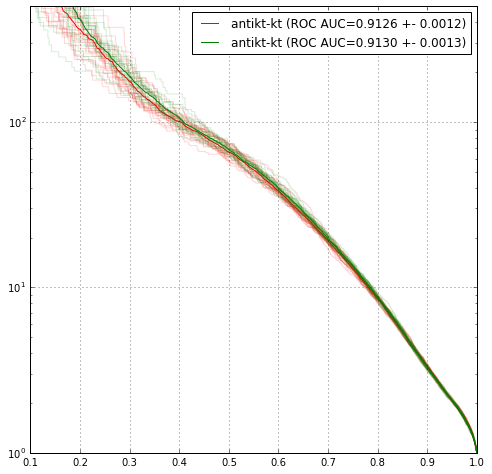

In [44]:
prefix = "antikt-kt"
color = "r"
tf = load_tf("../data/w-vs-qcd/final/%s-train.pickle" % prefix)
X, y, w = load_test(tf, "../data/w-vs-qcd/final/%s-test.pickle" % prefix) 
rocs, fprs, tprs = evaluate_models(X, y, w, "../models/jet-study/model-w-s-%s-[0-9]*.pickle" % prefix)
plot_rocs(rocs, fprs, tprs, label=prefix, color=color)

prefix = "antikt-kt"
color = "g"
# tf = load_tf("../data/w-vs-qcd/final/%s-train.pickle" % prefix)
# X, y, w = load_test(tf, "../data/w-vs-qcd/final/%s-test.pickle" % prefix) 
rocs, fprs, tprs = evaluate_models(X, y, w, "../models/jet-study/model-w-g-%s-[0-9]*.pickle" % prefix, func=grnn_predict_gated)
plot_rocs(rocs, fprs, tprs, label=prefix, color=color)

plot_show()

# Topologies

Loading training data...
	filename = ../data/w-vs-qcd/final/antikt-kt-train.pickle
	X size = 80000
	y size = 80000
Preprocessing...
Loading test data...
	filename = ../data/w-vs-qcd/final/antikt-kt-test.pickle
	X size = 20000
	y size = 20000
Preprocessing...
	X size = 7690
	y size = 7690
Loading ../models/jet-study/model-w-s-antikt-kt-20.pickle ROC AUC = 0.9127
Loading ../models/jet-study/model-w-s-antikt-kt-4.pickle ROC AUC = 0.9141
Loading ../models/jet-study/model-w-s-antikt-kt-7.pickle ROC AUC = 0.9135
Loading ../models/jet-study/model-w-s-antikt-kt-1.pickle ROC AUC = 0.9139
Loading ../models/jet-study/model-w-s-antikt-kt-6.pickle ROC AUC = 0.9123
Loading ../models/jet-study/model-w-s-antikt-kt-3.pickle ROC AUC = 0.9131
Loading ../models/jet-study/model-w-s-antikt-kt-17.pickle ROC AUC = 0.9125
Loading ../models/jet-study/model-w-s-antikt-kt-19.pickle ROC AUC = 0.9110
Loading ../models/jet-study/model-w-s-antikt-kt-10.pickle ROC AUC = 0.9140
Loading ../models/jet-study/model-w-s-ant

/home/gilles/anaconda3/envs/hep/lib/python2.7/site-packages/ipykernel/__main__.py:6: RuntimeWarning: divide by zero encountered in divide
/home/gilles/anaconda3/envs/hep/lib/python2.7/site-packages/ipykernel/__main__.py:7: RuntimeWarning: divide by zero encountered in divide


	filename = ../data/w-vs-qcd/final/antikt-cambridge-train.pickle
	X size = 80000
	y size = 80000
Preprocessing...
Loading test data...
	filename = ../data/w-vs-qcd/final/antikt-cambridge-test.pickle
	X size = 20000
	y size = 20000
Preprocessing...
	X size = 7690
	y size = 7690
Loading ../models/jet-study/model-w-s-antikt-cambridge-10.pickle ROC AUC = 0.9117
Loading ../models/jet-study/model-w-s-antikt-cambridge-15.pickle ROC AUC = 0.9119
Loading ../models/jet-study/model-w-s-antikt-cambridge-14.pickle ROC AUC = 0.9101
Loading ../models/jet-study/model-w-s-antikt-cambridge-12.pickle ROC AUC = 0.9142
Loading ../models/jet-study/model-w-s-antikt-cambridge-11.pickle ROC AUC = 0.9154
Loading ../models/jet-study/model-w-s-antikt-cambridge-16.pickle ROC AUC = 0.9131
Loading ../models/jet-study/model-w-s-antikt-cambridge-2.pickle ROC AUC = 0.9137
Loading ../models/jet-study/model-w-s-antikt-cambridge-5.pickle ROC AUC = 0.9114
Loading ../models/jet-study/model-w-s-antikt-cambridge-18.pickle ROC

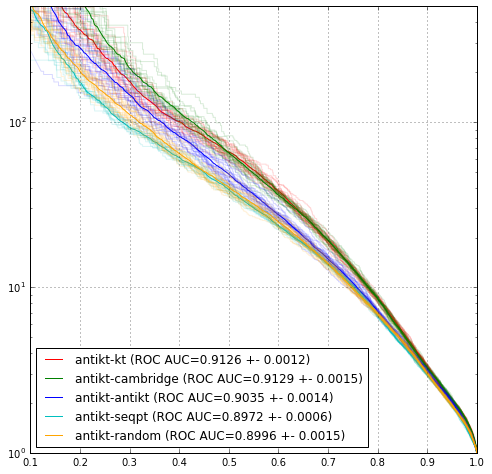

In [46]:
for prefix, color in [("antikt-kt", "r"), 
                      ("antikt-cambridge", "g"),
                      ("antikt-antikt", "b"),
                      ("antikt-seqpt", "c"),
                      ("antikt-random", "orange")]:
    tf = load_tf("../data/w-vs-qcd/final/%s-train.pickle" % prefix)
    X, y, w = load_test(tf, "../data/w-vs-qcd/final/%s-test.pickle" % prefix) 
    rocs, fprs, tprs = evaluate_models(X, y, w, "../models/jet-study/model-w-s-%s-[0-9]*.pickle" % prefix)
    plot_rocs(rocs, fprs, tprs, label=prefix, color=color)

plot_show()

# Particle vs Delphes vs images

Loading training data...
	filename = ../data/w-vs-qcd/final/antikt-kt-train.pickle
	X size = 80000
	y size = 80000
Preprocessing...
Loading test data...
	filename = ../data/w-vs-qcd/final/antikt-kt-test.pickle
	X size = 20000
	y size = 20000
Preprocessing...
	X size = 7690
	y size = 7690
Loading ../models/jet-study/model-w-s-antikt-kt-20.pickle
Loading ../models/jet-study/model-w-s-antikt-kt-4.pickle
Loading ../models/jet-study/model-w-s-antikt-kt-7.pickle
Loading ../models/jet-study/model-w-s-antikt-kt-1.pickle
Loading ../models/jet-study/model-w-s-antikt-kt-6.pickle
Loading ../models/jet-study/model-w-s-antikt-kt-3.pickle
Loading ../models/jet-study/model-w-s-antikt-kt-17.pickle
Loading ../models/jet-study/model-w-s-antikt-kt-19.pickle
Loading ../models/jet-study/model-w-s-antikt-kt-10.pickle
Loading ../models/jet-study/model-w-s-antikt-kt-12.pickle
Loading ../models/jet-study/model-w-s-antikt-kt-2.pickle
Loading ../models/jet-study/model-w-s-antikt-kt-18.pickle
Loading ../models/jet

/home/gilles/anaconda3/envs/hep/lib/python2.7/site-packages/ipykernel/__main__.py:6: RuntimeWarning: divide by zero encountered in divide
/home/gilles/anaconda3/envs/hep/lib/python2.7/site-packages/ipykernel/__main__.py:7: RuntimeWarning: divide by zero encountered in divide


Loading training data...
	filename = ../data/w-vs-qcd/final/antikt-kt-delphes-train.pickle
	X size = 80000
	y size = 80000
Preprocessing...
Loading test data...
	filename = ../data/w-vs-qcd/final/antikt-kt-delphes-test.pickle
	X size = 20000
	y size = 20000
Preprocessing...
	X size = 5886
	y size = 5886
Loading ../models/jet-study/model-w-s-antikt-kt-delphes-17.pickle
Loading ../models/jet-study/model-w-s-antikt-kt-delphes-16.pickle
Loading ../models/jet-study/model-w-s-antikt-kt-delphes-12.pickle
Loading ../models/jet-study/model-w-s-antikt-kt-delphes-10.pickle
Loading ../models/jet-study/model-w-s-antikt-kt-delphes-9.pickle
Loading ../models/jet-study/model-w-s-antikt-kt-delphes-5.pickle
Loading ../models/jet-study/model-w-s-antikt-kt-delphes-2.pickle
Loading ../models/jet-study/model-w-s-antikt-kt-delphes-15.pickle
Loading ../models/jet-study/model-w-s-antikt-kt-delphes-14.pickle
Loading ../models/jet-study/model-w-s-antikt-kt-delphes-7.pickle
Loading ../models/jet-study/model-w-s-a

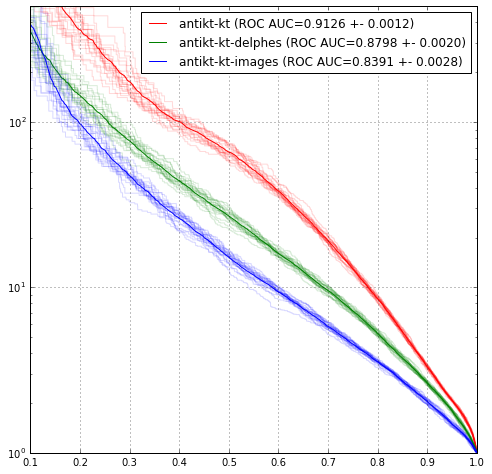

In [31]:
for prefix, color in [("antikt-kt", "r"), 
                      ("antikt-kt-delphes", "g"), 
                      ("antikt-kt-images", "b")]:
    tf = load_tf("../data/w-vs-qcd/final/%s-train.pickle" % prefix)
    X, y, w = load_test(tf, "../data/w-vs-qcd/final/%s-test.pickle" % prefix) 
    rocs, fprs, tprs = evaluate_models(X, y, w, "../models/jet-study/model-w-s-%s-[0-9]*.pickle" % prefix)
    plot_rocs(rocs, fprs, tprs, label=prefix, color=color)

plot_show()

# Trimming

Loading training data...
	filename = ../data/w-vs-qcd/final/antikt-kt-train.pickle
	X size = 80000
	y size = 80000
Preprocessing...
Loading test data...
	filename = ../data/w-vs-qcd/final/antikt-kt-test.pickle
	X size = 20000
	y size = 20000
Preprocessing...
	X size = 7690
	y size = 7690
Loading ../models/jet-study/model-w-s-antikt-kt-20.pickle ROC AUC = 0.9128
Loading ../models/jet-study/model-w-s-antikt-kt-4.pickle ROC AUC = 0.9141
Loading ../models/jet-study/model-w-s-antikt-kt-7.pickle ROC AUC = 0.9135
Loading ../models/jet-study/model-w-s-antikt-kt-1.pickle ROC AUC = 0.9139
Loading ../models/jet-study/model-w-s-antikt-kt-6.pickle ROC AUC = 0.9123
Loading ../models/jet-study/model-w-s-antikt-kt-3.pickle ROC AUC = 0.9131
Loading ../models/jet-study/model-w-s-antikt-kt-17.pickle ROC AUC = 0.9125
Loading ../models/jet-study/model-w-s-antikt-kt-19.pickle ROC AUC = 0.9110
Loading ../models/jet-study/model-w-s-antikt-kt-10.pickle ROC AUC = 0.9141
Loading ../models/jet-study/model-w-s-ant

/home/gilles/anaconda3/envs/hep/lib/python2.7/site-packages/ipykernel/__main__.py:6: RuntimeWarning: divide by zero encountered in divide
/home/gilles/anaconda3/envs/hep/lib/python2.7/site-packages/ipykernel/__main__.py:7: RuntimeWarning: divide by zero encountered in divide


	filename = ../data/w-vs-qcd/final/antikt-kt-train.pickle
	X size = 80000
	y size = 80000
Preprocessing...
Loading test data...
	filename = ../data/w-vs-qcd/final/antikt-kt-trimmed-test.pickle
	X size = 20000
	y size = 20000
Preprocessing...
	X size = 5060
	y size = 5060
Loading ../models/jet-study/model-w-s-antikt-kt-20.pickle ROC AUC = 0.8843
Loading ../models/jet-study/model-w-s-antikt-kt-4.pickle ROC AUC = 0.8842
Loading ../models/jet-study/model-w-s-antikt-kt-7.pickle ROC AUC = 0.8869
Loading ../models/jet-study/model-w-s-antikt-kt-1.pickle ROC AUC = 0.8886
Loading ../models/jet-study/model-w-s-antikt-kt-6.pickle ROC AUC = 0.8715
Loading ../models/jet-study/model-w-s-antikt-kt-3.pickle ROC AUC = 0.8852
Loading ../models/jet-study/model-w-s-antikt-kt-17.pickle ROC AUC = 0.8847
Loading ../models/jet-study/model-w-s-antikt-kt-19.pickle ROC AUC = 0.8854
Loading ../models/jet-study/model-w-s-antikt-kt-10.pickle ROC AUC = 0.8786
Loading ../models/jet-study/model-w-s-antikt-kt-12.pickle 

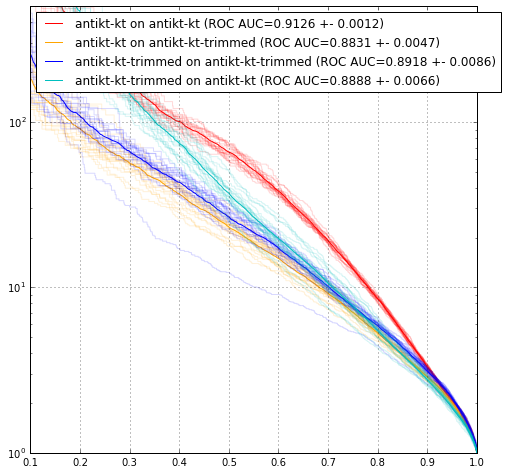

In [48]:
for prefix1, prefix2, color in [("antikt-kt", "antikt-kt", "r"), 
                                ("antikt-kt", "antikt-kt-trimmed", "orange"),
                                ("antikt-kt-trimmed", "antikt-kt-trimmed", "b"),
                                ("antikt-kt-trimmed", "antikt-kt", "c")]:
    tf = load_tf("../data/w-vs-qcd/final/%s-train.pickle" % prefix1)
    X, y, w = load_test(tf, "../data/w-vs-qcd/final/%s-test.pickle" % prefix2) 
    rocs, fprs, tprs = evaluate_models(X, y, w, "../models/jet-study/model-w-s-%s-[0-9]*.pickle" % prefix1)
    plot_rocs(rocs, fprs, tprs, label="%s on %s" % (prefix1, prefix2), color=color)

plot_show()

# Stereo